# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

Github link: https://github.com/mjlee177/Mod11_CarPrices.git

# Summary of Findings

The dataset is for 426k cars and contains 16 varaibles: 
- id
- region
- price
- year
- condition
- manufacturer
- model
- fuel type
- mileage
- title status
- transmission type
- VIN
- drive train
- size
- type
- color
- region
- state

We removed varaibles that are not useful for data analysis or there were too many variations:
- id
- region
- manufacturer
- model
- VIN
- 

We then modified these variables

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The business case for the historical used car data is for used car dealerships to approximate their sale prices (or dollar value to customers). This will also help with buy prices by simply taking the projected sale price and factoring in a dealership's mark-up.  The inputs are: price, year, make, model, condition, fuel type, mileage, title status, transmission type, drive train, size, type, color, region, and state.

# 1. Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa import arima_process
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
!pip install kaleido

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [11]:
#read in data file
veh = pd.read_csv('data/vehicles.csv')
#show dataset info
veh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [12]:
veh.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


## Numerical Data
First, we'll focus on the numerical data.  We can convert 'cylinders' to (disconinuous) numerical values and instead of 'year' we can use 'years_old'.

In [14]:
# convert 'cylinders' to numerical values for regression
veh['cylinders'] = veh['cylinders'].replace({
    '8 cylinders': 8,
    '6 cylinders': 6,
    '4 cylinders': 4,
    '5 cylinders': 5,
    '3 cylinders': 3,
    '10 cylinders': 10,
    '12 cylinders': 12,
    'other': None
}).astype('float')

# create a new column for 'years_old', which will make more sense than 'year' for trend data
#get current year fromt the data and show result
current_year = veh['year'].max()
print("current year:",current_year)
# create new column
veh['years_old'] = current_year - veh['year']

current year: 2022.0


### Regression Candidates
Next, let's look at the data to see which non-numerical features are candidates for OneHotEncoder.  Good candidates can't have too many unique values due to computational constraints.

In [16]:
veh.describe(include = ['object','category'])

,region,manufacturer,model,condition,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,356209,405117,336524,261,131904,63465,87056,79285,50614


Looking at the unique row, we'll select 13 as the cutoff for OneHotEncoder features to include in our regressions.  Now we'll make some lists that may prove convenient later.

In [18]:
# list of non-numerical features
non_num_features = ['region', 'manufacturer', 'model','transmission','drive','size','type','paint_color','state']
# list of numerical features for possible use later
num_features = ['years_old','cylinders','odometer']
# make regression features set
regression_features = ['price','years_old','condition','cylinders','fuel','odometer','title_status','transmission','drive','size','type','paint_color']

## Duplicate Data
This combination should not occur more than once (regardless of other column entries):
- VIN, price, and odometer

In [20]:
#how many unique VIN?
veh['VIN'].nunique()

118246

In [21]:
# drop and show how many columns will drop by eliminating duplicates of the combo of same VIN, price, and odometer
veh_drop_duplicates = veh.drop_duplicates(subset = ['VIN','price','odometer'])
print("Number of dropped rows: ", veh.shape[0] - veh_drop_duplicates.shape[0])
veh_drop_duplicates.info()

Number of dropped rows:  215109
<class 'pandas.core.frame.DataFrame'>
Index: 211771 entries, 0 to 426838
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            211771 non-null  int64  
 1   region        211771 non-null  object 
 2   price         211771 non-null  int64  
 3   year          211090 non-null  float64
 4   manufacturer  203395 non-null  object 
 5   model         209174 non-null  object 
 6   condition     123587 non-null  object 
 7   cylinders     134078 non-null  float64
 8   fuel          210029 non-null  object 
 9   odometer      209748 non-null  float64
 10  title_status  207566 non-null  object 
 11  transmission  210423 non-null  object 
 12  VIN           122920 non-null  object 
 13  drive         154391 non-null  object 
 14  size          73041 non-null   object 
 15  type          163607 non-null  object 
 16  paint_color   150600 non-null  object 
 17  state         211771 

Next, we will look at the raw data by hand to check for suspect or nonsensical entries.<br>
It looks like data between 1k < price < 350k is bad.  A lot of 0 cost used cars and very recent cars for less than 1k.  Some trucks sold for over 350k makes no sense.<br>

## Bad Pricing Data

In [24]:
# original run was done with lower limit 1k, changed to 5k after frequency plots
# The data looks suspect for price < $5k and > $350k, filter out the data
filtered_veh_data = veh_drop_duplicates[(veh_drop_duplicates['price'] > 5000) & (veh_drop_duplicates['price'] < 350000)].copy()
#what % of data do we lose?
percent_less_5k = 100*veh_drop_duplicates[veh_drop_duplicates['price'] < 5000]['price'].count()/veh_drop_duplicates['price'].count()
percent_greater_350k = 100*veh_drop_duplicates[veh_drop_duplicates['price'] > 350000]['price'].count()/veh_drop_duplicates['price'].count()
print("% of prices below 5k:",percent_less_5k)
print("% of prices above 350k:",percent_greater_350k)
print("# entries left:",filtered_veh_data.shape[0])

% of prices below 5k: 23.869179443833197
% of prices above 350k: 0.024082617544422986
# entries left: 160247


We looked at the data and it's bad between 1k and $350k.  These entries were filtered out and we lost about 11% of the data.<br>
2nd pass, we increased the lower limit to 5k, 24% of data is now gone.

In [26]:
filtered_veh_data.loc[:,'log_price'] = np.log(filtered_veh_data['price'])
regression_features.append('log_price')
# try log price if there is time

<Figure size 1000x1200 with 0 Axes>

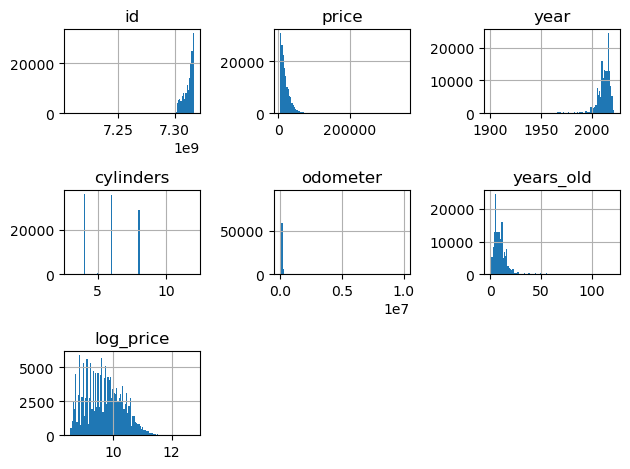

In [27]:
# frequency plots
plt.figure(figsize=(10,12))
filtered_veh_data.hist(bins=100)
plt.xlabel('Frequency')
plt.title('Frequency Plots')
plt.savefig('images/FreqPlots.png')
plt.tight_layout()
plt.show()

An observation is that the price frequency plot looks logarithmic after around 5k.  Let's change the lower limit to 5k and add a column for the log of price for use during regression.<br>
We will add the 'log price' column before the frequency plots so we can visualize the log data.

### Scatterplots
Now we do scatterplots for the numerical features<br>

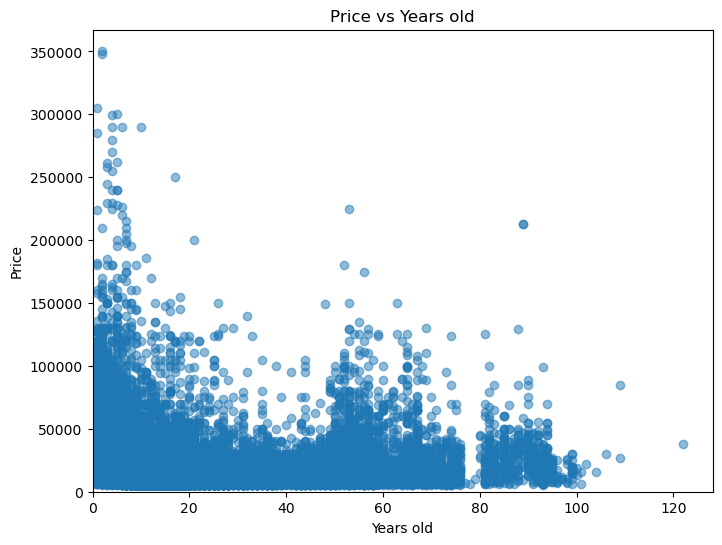

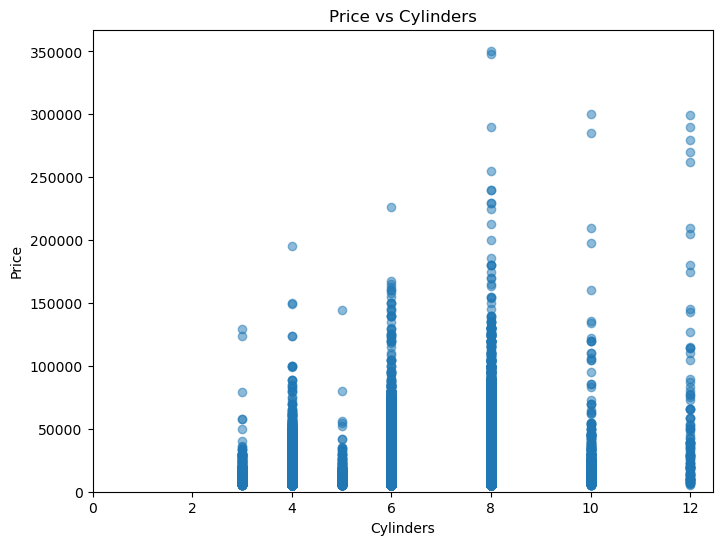

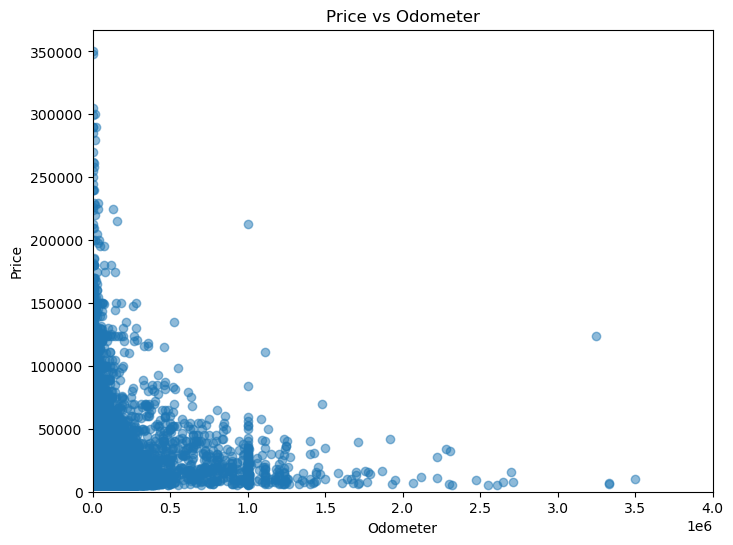

In [30]:
# Scatter plot for 'price' vs 'year'
plt.figure(figsize=(8, 6))
plt.scatter(filtered_veh_data['years_old'], filtered_veh_data['price'], alpha=0.5)
plt.xlabel('Years old')
plt.ylabel('Price')
plt.title('Price vs Years old')
plt.xlim(0)  # Set x-axis to start at 0
plt.ylim(0)  # Set y-axis to start at 0plt.title('Price vs Year')
plt.savefig('images/YearsPriceScatter.png')
plt.show()

# Scatter plot for 'price' vs 'cylinders'
plt.figure(figsize=(8, 6))
plt.scatter(filtered_veh_data['cylinders'], filtered_veh_data['price'], alpha=0.5)
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.title('Price vs Cylinders')
plt.xlim(0)  # Set x-axis to start at 0
plt.ylim(0)  # Set y-axis to start at 0plt.title('Price vs Cylinders')
plt.savefig('images/CylindersPriceScatter.png')
plt.show()

# Scatter plot for 'price' vs 'odometer'
plt.figure(figsize=(8, 6))
plt.scatter(filtered_veh_data['odometer'], filtered_veh_data['price'], alpha=0.5)
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.title('Price vs Odometer')
plt.ylim(0)  # Set y-axis to start at 0
plt.xlim(0,4000000)
plt.savefig('images/OdometerPriceScatter.png')
plt.show()

## Remove Outliers
- Price vs Years
    - Price 225000, 53 yrs old
    - price 213000, 89 yrs old
- Price vs Odometer
    - price 21300, 999999 odometer
    - price 123456, 3245000 odometer

In [32]:
# Define the conditions for the rows to remove
rows_to_remove = (
    ((filtered_veh_data['price'] == 225000) & (filtered_veh_data['years_old'] == 53)) |
    ((filtered_veh_data['price'] == 213000) & (filtered_veh_data['years_old'] == 89)) |
    ((filtered_veh_data['price'] == 21300) & (filtered_veh_data['odometer'] == 999999)) |
    ((filtered_veh_data['price'] == 123456) & (filtered_veh_data['odometer'] == 3245000))
)

# Remove the rows matching the conditions
nooutliers_veh_data = filtered_veh_data[~rows_to_remove]

# Display the updated DataFrame
nooutliers_veh_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160243 entries, 0 to 426838
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            160243 non-null  int64  
 1   region        160243 non-null  object 
 2   price         160243 non-null  int64  
 3   year          159600 non-null  float64
 4   manufacturer  154143 non-null  object 
 5   model         158558 non-null  object 
 6   condition     94661 non-null   object 
 7   cylinders     102041 non-null  float64
 8   fuel          158859 non-null  object 
 9   odometer      159387 non-null  float64
 10  title_status  157283 non-null  object 
 11  transmission  159355 non-null  object 
 12  VIN           96141 non-null   object 
 13  drive         119326 non-null  object 
 14  size          55073 non-null   object 
 15  type          126174 non-null  object 
 16  paint_color   119022 non-null  object 
 17  state         160243 non-null  object 
 18  years_old

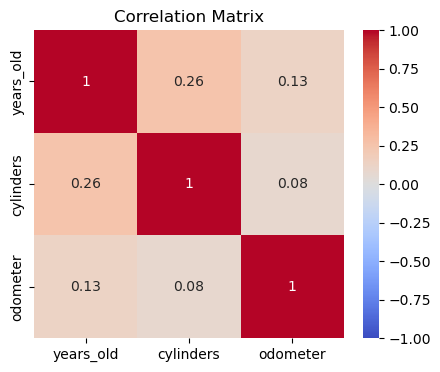

In [33]:
# Create a correlation heatmap using just the numerical features
plt.figure(figsize=(5, 4))
sns.heatmap(nooutliers_veh_data[num_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('images/CorrMatrix.png')
plt.show()

No significant correlations so data can't be simplified or eliminated

## Blank Entries
Now that we have our final data set, let's look at blanks.

In [36]:
# Look at which features have blanks and how many total
print(nooutliers_veh_data.isnull().sum(), '\n')
print(nooutliers_veh_data.isnull().sum().sum(), '\n')

id                   0
region               0
price                0
year               643
manufacturer      6100
model             1685
condition        65582
cylinders        58202
fuel              1384
odometer           856
title_status      2960
transmission       888
VIN              64102
drive            40917
size            105170
type             34069
paint_color      41221
state                0
years_old          643
log_price            0
dtype: int64 

424422 



In [37]:
print(regression_features)

['price', 'years_old', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'log_price']


 Size (105,170), Condition (65,582), Cylinders (58,202), Drive (40,917), paint_color (41,221), and Type (34,069) all contain a lot of blanks.<br>

In [39]:
nooutliers_veh_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160243 entries, 0 to 426838
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            160243 non-null  int64  
 1   region        160243 non-null  object 
 2   price         160243 non-null  int64  
 3   year          159600 non-null  float64
 4   manufacturer  154143 non-null  object 
 5   model         158558 non-null  object 
 6   condition     94661 non-null   object 
 7   cylinders     102041 non-null  float64
 8   fuel          158859 non-null  object 
 9   odometer      159387 non-null  float64
 10  title_status  157283 non-null  object 
 11  transmission  159355 non-null  object 
 12  VIN           96141 non-null   object 
 13  drive         119326 non-null  object 
 14  size          55073 non-null   object 
 15  type          126174 non-null  object 
 16  paint_color   119022 non-null  object 
 17  state         160243 non-null  object 
 18  years_old

Note, I tried to run RFE but I'm using Anaconda online and it crapped out every time.

In [41]:
#prep for RFE by dropping na
# RFE_data = nooutliers_veh_data.dropna()
# print(RFE_data.shape)

# X = RFE_data.drop(['price', 'log_price'],axis=1)
# y= RFE_data['price']

# Try PFE to see which features are most important

# preprocessor = ColumnTransformer([
#     ('ohe',OneHotEncoder(), non_num_features),
#     ('scale',StandardScaler(),num_features)
# ])

# estimator = LogisticRegression(max_iter=1000)
# rfe = RFE(estimator=estimator,n_features_to_select=5)

# pipeline = Pipeline([
#     ('preprocessor',preprocessor),
#     ('rfe',rfe)
# ])

# pipeline.fit(X,y)

# selected_features = pipeline.named_steps['rfe'].support_
# print("selected features:" , selected_features)

In [42]:
# List of columns to check for missing values
columns_to_check = ['size','condition', 'cylinders', 'drive', 'paint_color', 'type']

# Count rows with missing values in the specified columns
rows_with_na = nooutliers_veh_data[columns_to_check].isna().any(axis=1).sum()
percent_dec = round(100*(rows_with_na) / (nooutliers_veh_data.shape[0]),2)

# Display the result
print(f"Current rows: {nooutliers_veh_data.shape[0]}")
print(f"Number of rows that would be dropped: {rows_with_na}")
print(f"% dropped rows: {percent_dec}%")

Current rows: 160243
Number of rows that would be dropped: 120804
% dropped rows: 75.39%


Too many rows to drop, let's drop columns instead so we at least use a good amount of data.

In [44]:
# Remove features with too many missing entries
regression_features.remove('condition')
regression_features.remove('drive')
regression_features.remove('cylinders')
regression_features.remove('size')
regression_features.remove('type')
regression_features.remove('paint_color')

print(regression_features)

['price', 'years_old', 'fuel', 'odometer', 'title_status', 'transmission', 'log_price']


In [45]:
# craete the final dataset we will use
final_veh_data_w_na = nooutliers_veh_data[regression_features] # only use columns selected for regression
print(f"Final data w/o dropping na yet: {final_veh_data_w_na.shape[0]}")

#drop na
final_veh_data = final_veh_data_w_na.dropna()
dropped_from_na = final_veh_data_w_na.shape[0] - final_veh_data.shape[0]
# show how many entried removed from dropping na
print(f"Number of col removed from dropna: {dropped_from_na}")
final_veh_data.info()

Final data w/o dropping na yet: 160243
Number of col removed from dropna: 5867
<class 'pandas.core.frame.DataFrame'>
Index: 154376 entries, 27 to 426838
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         154376 non-null  int64  
 1   years_old     154376 non-null  float64
 2   fuel          154376 non-null  object 
 3   odometer      154376 non-null  float64
 4   title_status  154376 non-null  object 
 5   transmission  154376 non-null  object 
 6   log_price     154376 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.4+ MB


# 2. Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

The approach taken in this paper was to do Data Preparation the data during Data Understanding.  In this way, the live Data Preparation acted like a funnel to remove bad data and then look at the remaining information.  Data Preparation steps so far:
- remove duplicate entries (426,880 - 215,109 = 211,771 entries remaining)
- remove non-sensical pricing data (< 5000 and > 350000) (211,771 - 61,524 = 160,247 entries remaining)
- remove outliers (160,247 - 4 = 160,243)
- remove features with too many NA (160,243 - 5867 = 154,376 entries remaining)

Overall we have 154,376/426,880 = 36% of the original data remaining.

# 3. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## Train-test-split

In [50]:
X = final_veh_data.drop(['price', 'log_price'],axis=1)
y = final_veh_data['price']

X.info()
print("============\n============")
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154376 entries, 27 to 426838
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   years_old     154376 non-null  float64
 1   fuel          154376 non-null  object 
 2   odometer      154376 non-null  float64
 3   title_status  154376 non-null  object 
 4   transmission  154376 non-null  object 
dtypes: float64(2), object(3)
memory usage: 7.1+ MB
<class 'pandas.core.series.Series'>
Index: 154376 entries, 27 to 426838
Series name: price
Non-Null Count   Dtype
--------------   -----
154376 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [52]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train.dtypes)
print(y_train.dtypes)
print(X_test.dtypes)
print(y_test.dtypes)

(108063, 5)
(108063,)
(46313, 5)
(46313,)
years_old       float64
fuel             object
odometer        float64
title_status     object
transmission     object
dtype: object
int64
years_old       float64
fuel             object
odometer        float64
title_status     object
transmission     object
dtype: object
int64


## Pipelines

In [54]:
#create transformer with OneHotEncode, remainder feed to StandardScaler
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'),['fuel','title_status','transmission']), remainder=StandardScaler())
# linear regression pipe
base_pipe_lin = Pipeline([
    ('transformer',transformer),
    ('linreg',LinearRegression())
])
base_pipe_lin.fit(X_train,y_train)

# ridge pipe
base_pipe_ridge = Pipeline([
    ('transformer',transformer),
    ('ridge',Ridge(alpha=0.1))
])
base_pipe_ridge.fit(X_train,y_train)

# lasso pipe
base_pipe_lasso = Pipeline([
    ('transformer',transformer),
    ('lasso',Lasso(alpha=0.1,max_iter=10000))
])
base_pipe_lasso.fit(X_train,y_train)

# Polynomial Features pipe
base_pipe_poly = Pipeline([
    ('transformer',transformer),
    ('poly',PolynomialFeatures(degree=2,include_bias=False)),
    ('ridge',Ridge())
])
base_pipe_poly.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['fuel', 'title_status',
                                                   'transmission'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])

## Predictions

In [56]:
pred_lin_train = base_pipe_lin.predict(X_train)
pred_lin_test = base_pipe_lin.predict(X_test)


pred_ridge_train = base_pipe_ridge.predict(X_train)
pred_ridge_test = base_pipe_ridge.predict(X_test)

pred_lasso_train = base_pipe_lasso.predict(X_train)
pred_lasso_test = base_pipe_lasso.predict(X_test)

pred_poly_train = base_pipe_poly.predict(X_train) 
pred_poly_test = base_pipe_poly.predict(X_test)

print(pred_lin_train.shape)
print(pred_lin_test.shape)
print(pred_ridge_train.shape)
print(pred_ridge_test.shape)
print(pred_poly_train.shape)
print(pred_poly_test.shape)

(108063,)
(46313,)
(108063,)
(46313,)
(108063,)
(46313,)


In [57]:
# For Linear Regression
linreg_coeff = base_pipe_lin.named_steps['linreg'].coef_
print("Linear Regression Coefficients:", linreg_coeff)

# For Ridge Regression 
ridge_coeff = base_pipe_ridge.named_steps['ridge'].coef_
print("Ridge Coefficients:", ridge_coeff)

# For Lasso Regression
lasso_coeff = base_pipe_lasso.named_steps['lasso'].coef_
print("Lasso Coefficients:", lasso_coeff)

grid_coeff = base_pipe_poly.named_steps['ridge'].coef_
print("Grid Coefficients:", grid_coeff)

Linear Regression Coefficients: [-4.36868037e+15 -4.36868037e+15 -4.36868037e+15 -4.36868037e+15
 -4.36868037e+15 -3.22919715e+16 -3.22919715e+16 -3.22919715e+16
 -3.22919715e+16 -3.22919715e+16 -3.22919715e+16  6.58636259e+15
  6.58636259e+15  6.58636259e+15 -2.64952173e+03 -2.11412634e+03]
Ridge Coefficients: [11147.57920907   918.64241595 -4110.79635919 -7810.90468492
  -144.52059312 -2060.75492002  2665.83646616  1817.07958846
 11930.30183214 -6915.34978695 -7437.1131782  -2710.28951502
    40.4221498   2669.86737106 -2648.55469496 -2115.05014808]
Lasso Coefficients: [ 1.12898673e+04  1.03926067e+03 -3.96687753e+03 -7.66002230e+03
  0.00000000e+00 -9.00704257e-02  4.71249252e+03  3.72938291e+03
  1.33839066e+04 -4.85084058e+03 -5.36748262e+03 -2.75063461e+03
  0.00000000e+00  2.62849166e+03 -2.64795833e+03 -2.11436098e+03]
Grid Coefficients: [  4350.26284297   4893.84215997  -3034.48336728  -5833.53487799
   -376.08675885  -1523.15003551  -1148.73590697   4609.52281914
   3554.1771

The Linear Regression coefficients are abnormally large, which indicates overfitting.  We should use Lasso or Ridge instead.

In [59]:
# Create a table for the coefficients

# Get feature names after transformation
feature_names = transformer.get_feature_names_out()

# Create a DataFrame to compare coefficients across models
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Linear Regression": linreg_coeff,
    "Ridge Regression": ridge_coeff,
    "Lasso Regression": lasso_coeff
})

# Display the table
print(coefficients_df)

                                   Feature  Linear Regression  \
0               onehotencoder__fuel_diesel      -4.368680e+15   
1             onehotencoder__fuel_electric      -4.368680e+15   
2                  onehotencoder__fuel_gas      -4.368680e+15   
3               onehotencoder__fuel_hybrid      -4.368680e+15   
4                onehotencoder__fuel_other      -4.368680e+15   
5        onehotencoder__title_status_clean      -3.229197e+16   
6         onehotencoder__title_status_lien      -3.229197e+16   
7      onehotencoder__title_status_missing      -3.229197e+16   
8   onehotencoder__title_status_parts only      -3.229197e+16   
9      onehotencoder__title_status_rebuilt      -3.229197e+16   
10     onehotencoder__title_status_salvage      -3.229197e+16   
11   onehotencoder__transmission_automatic       6.586363e+15   
12      onehotencoder__transmission_manual       6.586363e+15   
13       onehotencoder__transmission_other       6.586363e+15   
14                    rem

In [60]:
# Create a table for the polynomial coefficients
# Get feature names from the PolynomialFeatures transformer
poly_feature_names = base_pipe_poly.named_steps['poly'].get_feature_names_out(
    input_features=transformer.get_feature_names_out()
)

# Create a DataFrame to map features to their coefficients
grid_coeff_df = pd.DataFrame({
    "Feature": poly_feature_names,
    "Grid Coefficient": grid_coeff
})

# Sort by the absolute value of the coefficients for better readability
grid_coeff_df["Abs Coefficient"] = grid_coeff_df["Grid Coefficient"].abs()
grid_coeff_df = grid_coeff_df.sort_values(by="Abs Coefficient", ascending=False)

# Display the table
print(grid_coeff_df)

                                               Feature  Grid Coefficient  \
43   onehotencoder__fuel_electric onehotencoder__tr...      17609.773351   
40   onehotencoder__fuel_electric onehotencoder__ti...      11546.241673   
78   onehotencoder__fuel_other onehotencoder__title...      10652.024683   
23   onehotencoder__fuel_diesel onehotencoder__titl...      10519.445719   
70   onehotencoder__fuel_hybrid onehotencoder__tran...     -10278.659217   
..                                                 ...               ...   
101  onehotencoder__title_status_lien onehotencoder...          0.000000   
108  onehotencoder__title_status_missing onehotenco...          0.000000   
109  onehotencoder__title_status_missing onehotenco...          0.000000   
110  onehotencoder__title_status_missing onehotenco...          0.000000   
38   onehotencoder__fuel_electric onehotencoder__ti...          0.000000   

     Abs Coefficient  
43      17609.773351  
40      11546.241673  
78      10652.0246

Note: this table is too large but it is made to show the interpretation of the coefficients.

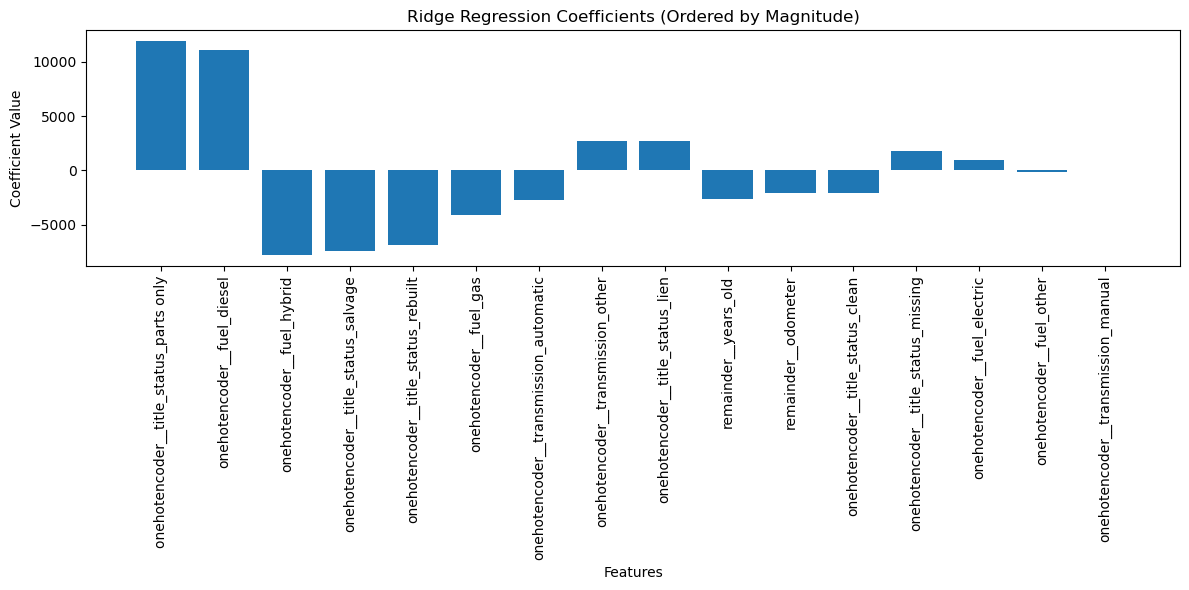

In [62]:
# plot Ridge coeff
ridge_coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Ridge Coefficient": ridge_coeff
})

# Sort the coefficients by absolute value
ridge_coeff_df["Abs Coefficient"] = ridge_coeff_df["Ridge Coefficient"].abs()
ridge_coeff_df = ridge_coeff_df.sort_values(by="Abs Coefficient", ascending=False)

# Plot the ordered coefficients
plt.figure(figsize=(12, 6))
plt.bar(ridge_coeff_df["Feature"], ridge_coeff_df["Ridge Coefficient"])
plt.title("Ridge Regression Coefficients (Ordered by Magnitude)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)  
plt.tight_layout()
plt.savefig('images/RidgeCoeff.png')
plt.show()

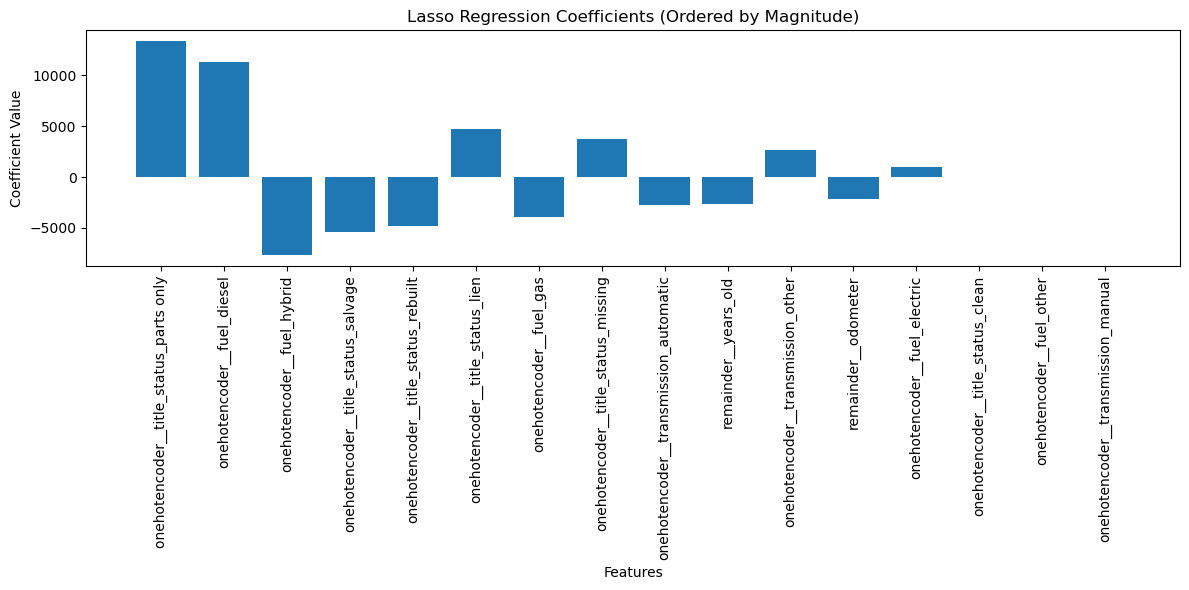

In [63]:
# Plot Lasso coeff
lasso_coeff_df = pd.DataFrame({
    "Feature": feature_names,  
    "Lasso Coefficient": lasso_coeff 
})

# Sort the coefficients by absolute value
lasso_coeff_df["Abs Coefficient"] = lasso_coeff_df["Lasso Coefficient"].abs()
lasso_coeff_df = lasso_coeff_df.sort_values(by="Abs Coefficient", ascending=False)

# Plot the ordered coefficients
plt.figure(figsize=(12, 6))
plt.bar(lasso_coeff_df["Feature"], lasso_coeff_df["Lasso Coefficient"])
plt.title("Lasso Regression Coefficients (Ordered by Magnitude)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)  
plt.tight_layout()
plt.savefig('images/LassoCoeff.png')
plt.show()

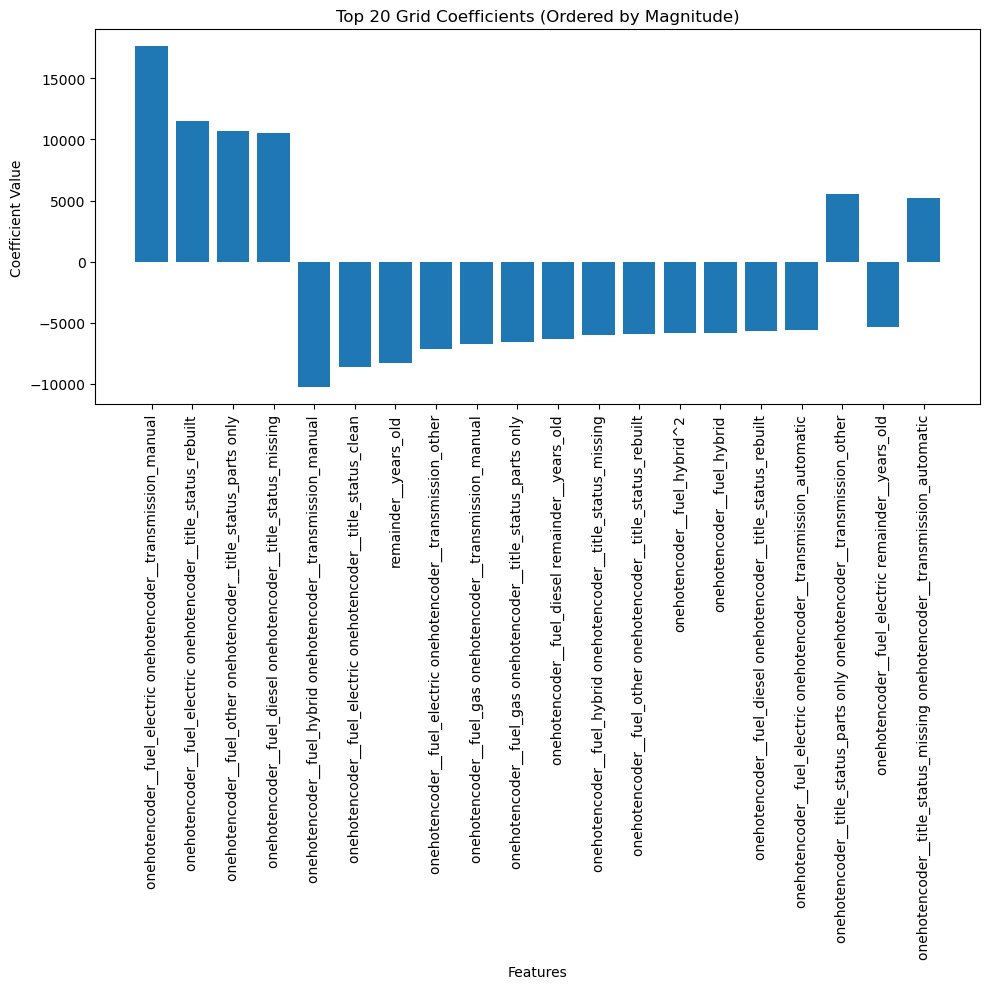

In [64]:
# Plot the Poly coefficients
grid_coeff_df = pd.DataFrame({
    "Feature": poly_feature_names,  
    "Grid Coefficient": grid_coeff
})

# Sort by absolute coefficient values
grid_coeff_df["Abs Coefficient"] = grid_coeff_df["Grid Coefficient"].abs()
grid_coeff_df = grid_coeff_df.sort_values(by="Abs Coefficient", ascending=False)

# Plot the top 20 coefficients
top_features = grid_coeff_df.head(20)  
plt.figure(figsize=(10, 10))
plt.bar(top_features["Feature"], top_features["Grid Coefficient"])
plt.title("Top 20 Grid Coefficients (Ordered by Magnitude)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/GridCoefficients.png")
plt.show()

In [65]:
# error calculations
y_train.shape

#linreg_mse = mean_squared_error(y_train, pred_lin_train)

(108063,)

In [66]:
#eror metrics function
def error_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    errors = {}
    
    # Errors for train data
    errors["Train_MAE"] = mean_absolute_error(y_train_true, y_train_pred)
    errors["Train_MSE"] = mean_squared_error(y_train_true, y_train_pred)
    errors["Train_RMSE"] = np.sqrt(errors["Train_MSE"])
    errors["Train_R2_Score"] = r2_score(y_train_true, y_train_pred)
    
    # Errors for test data
    errors["Test_MAE"] = mean_absolute_error(y_test_true, y_test_pred)
    errors["Test_MSE"] = mean_squared_error(y_test_true, y_test_pred)
    errors["Test_RMSE"] = np.sqrt(errors["Test_MSE"])
    errors["Test_R2_Score"] = r2_score(y_test_true, y_test_pred)
    
    return errors

model_evaluation = []

In [67]:
# error metrics

# linear regression errors
error_lr = error_metrics(y_train, pred_lin_train, y_test, pred_lin_test)
#print("Linear regression errors: \n",error_lr)

# Ridge errors
error_ridge = error_metrics(y_train, pred_ridge_train, y_test, pred_ridge_test)
#print("Linear regression errors: \n",error_ridge)

# Lasso errors
error_lasso = error_metrics(y_train, pred_lasso_train, y_test, pred_lasso_test)
#print("Linear regression errors: \n",error_lasso)

# Error matrix
model_errors = {
    "Linear Regression": error_lr,
    "Ridge Regression": error_ridge,
    "Lasso Regression": error_lasso
}

# Convert the dictionary into a pandas DataFrame
error_df = pd.DataFrame.from_dict(model_errors)
# Transpose the DataFrame to make error metrics as rows
error_df = error_df.transpose()
# Swap rows and columns by transposing again
error_df = error_df.T

# Display the table
print(error_df)

                Linear Regression  Ridge Regression  Lasso Regression
Train_MAE            9.111461e+03      9.109781e+03      9.109908e+03
Train_MSE            1.811133e+08      1.811139e+08      1.811140e+08
Train_RMSE           1.345784e+04      1.345786e+04      1.345786e+04
Train_R2_Score       1.419516e-01      1.419488e-01      1.419484e-01
Test_MAE             9.089624e+03      9.088145e+03      9.088297e+03
Test_MSE             1.772370e+08      1.772498e+08      1.772495e+08
Test_RMSE            1.331304e+04      1.331352e+04      1.331351e+04
Test_R2_Score        1.445957e-01      1.445342e-01      1.445352e-01


Ridge and Lasso Regression resulted in a slightly better training mean squared error but all errors are essentially the same.  So, it doens't matter which we use for this model.<br>
R2 scores are very bad at 0.14<br>
Let's try some Grid Searches to optimize hyperparameters

## Grid Search

In [70]:
param_grid = {
    'ridge__alpha':[0.1,0.01],
    'poly__degree':[2,3]
}

grid_search = GridSearchCV(base_pipe_poly,param_grid,cv=5,scoring='neg_mean_squared_error',error_score='raise')
grid_search.fit(X,y)
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print(best_model)

pred_Grid_train = best_model.predict(X_train)
pred_Grid_test = best_model.predict(X_test)

# GridSearchCV errors
error_Grid = error_metrics(y_train, pred_Grid_train, y_test, pred_Grid_test)
error_df['GridSearchCV'] = error_Grid
print(error_df)

Best Parameters: {'poly__degree': 2, 'ridge__alpha': 0.1}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['fuel', 'title_status',
                                                   'transmission'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=0.1))])
                Linear Regression  Ridge Regression  Lasso Regression  \
Train_MAE            9.111461e+03      9.109781e+03      9.109908e+03   
Train_MSE            1.811133e+08      1.811139e+08      1.811140e+08   
Train_RMSE           1.345784e+04      1.345786e+04      1.345786e+04   
Train_R2_Score       1.419516e-01      1.419488e-01      1.419484e-01   
Test_MAE             9.089624e+03      9.088145e+03      9.088297e+03   


The best we were able to do is R2 of 0.35 with Ridge alpha = 0.1 and polynomial = 2.  MAE, MSE, and RMSE are also the lowest for these parameters.<br>
If we had more time, we could have looked at different filtering options and substituting in different features we eliminated due to too many NA values.<br>
It was out of the scope of this project for week 11, but we also could have imputed some data instead of removing NA's.<br>
If we had more computing power, we could have explored RFE and more hyperparameters in GridSearchCV.  When I put too many in, Anaconda online did not work.<br>

## Visualize Results

In [73]:
print("y_train length:", len(y_train))
print("pred_ridge_train length:", len(pred_ridge_train))
print("pred_lasso_train length:", len(pred_lasso_train))
print("pred_lin_train length:", len(pred_lin_train))
print("pred_Grid_train length:", len(pred_Grid_train))

y_train length: 108063
pred_ridge_train length: 108063
pred_lasso_train length: 108063
pred_lin_train length: 108063
pred_Grid_train length: 108063


In [74]:
# Create dataframe for plotting
y_train = y_train.reset_index(drop=True)
y_train_df = pd.DataFrame({
    'actual': y_train,
    'ridge': pred_ridge_train,
    'lasso': pred_lasso_train,
    'linear': pred_lin_train,
    'Grid': pred_Grid_train
})

# Print the DataFrame
print(y_train_df.head(5))

   actual         ridge         lasso   linear          Grid
0   21900  20301.626172  20301.250028  20316.0  25126.964259
1    9300  17192.030162  17192.431421  17208.0  14366.187181
2   20590  28589.491187  28588.926297  28640.0  23863.180407
3    9895  17443.283824  17443.760433  17464.0  13951.875515
4    6900  17146.527053  17146.969341  17160.0  13872.740153


In [133]:
fig = y_train_df.sort_index().plot(kind='line',backend='plotly',title='Train Data Performance')
fig.update_layout(
    xaxis=dict(range=[y_train_df.index.min(), y_train_df.index.max()]),
    #xaxis_title='Index (Data Points)',
    yaxis_title='Price',
    title='Train Data Performance'
)
fig.write_image('images/TrainPredictions.png')
# Please see images folder, showing here made the notebook too large to upload to Github

Note: showing image made the notebook file too large for Github, instead a screenshot is pasted.
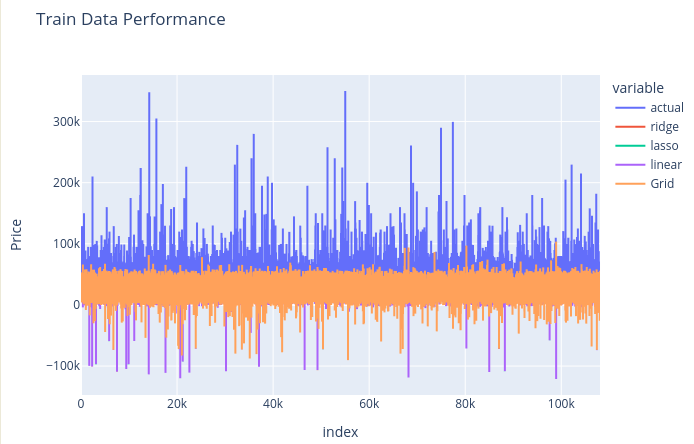

In [134]:
# Plot the graph with x-axis restricted between 0 and 1k
fig = y_train_df.sort_index().plot(kind='line', backend='plotly', title='Train Data Performance')

# Update the layout to restrict x-axis range
fig.update_layout(
    xaxis=dict(range=[0, 1000]),
    title='Train Data Performance (x-axis 0 to 1k)'
)
fig.write_image('images/TrainPredictionsZoomed.png')
# Please see images folder, showing here made the notebook too large to upload to Github

Note: showing image made the notebook file too large for Github, instead a screenshot is pasted.
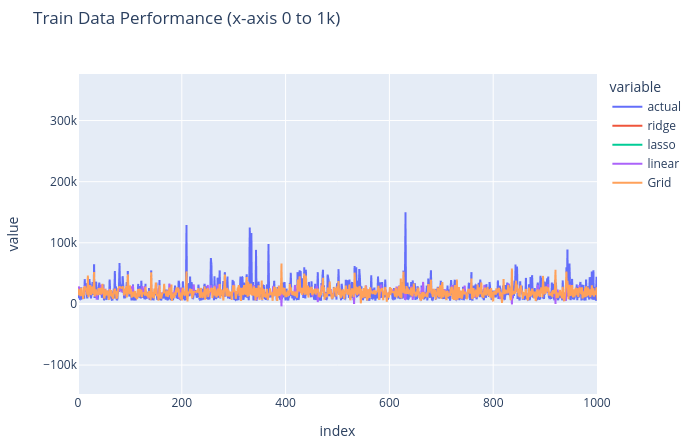

In [77]:
# Create dataframe for plotting
y_test = y_test.reset_index(drop=True)
y_test_df = pd.DataFrame({
    'actual': y_test,
    'ridge': pred_ridge_test,
    'lasso': pred_lasso_test,
    'linear': pred_lin_test,
    'Grid': pred_Grid_test
})

# Print the DataFrame
print(y_test_df.head(5))

   actual         ridge         lasso   linear          Grid
0   26995  20989.080948  20988.533211  21004.0  27853.444530
1   10500  20768.340567  20755.081639  20432.0  12444.682938
2   10995  15796.494493  15797.298067  15812.0   9543.939090
3    5500  27665.975345  27665.859398  27708.0   4453.733358
4   11500  18088.491980  18088.732151  18104.0  16678.089760


In [151]:
fig = y_test_df.sort_index().plot(kind='line',backend='plotly',title='Test Data Performance')
fig.update_layout(
    xaxis=dict(range=[y_test_df.index.min(), y_test_df.index.max()]),
    #xaxis_title='Index (Data Points)',
    yaxis_title='Price',
    title='Test Data Performance'
)
fig.write_image('images/TestPredictions.png')
# Please see images folder, showing here made the notebook too large to upload to Github

Note: showing image made the notebook file too large for Github, instead a screenshot is pasted.
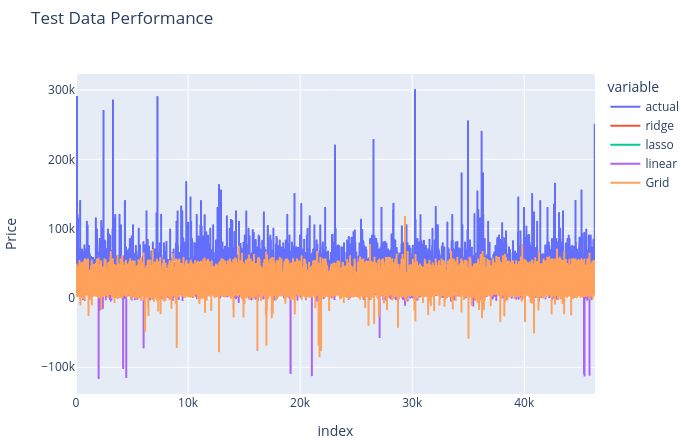

In [152]:
# Plot the graph with x-axis restricted between 0 and 1k
fig = y_test_df.sort_index().plot(kind='line', backend='plotly', title='Test Data Performance')

# Update the layout to restrict x-axis range
fig.update_layout(
    xaxis=dict(range=[0, 1000]),
    title='Test Data Performance (x-axis 0 to 1k)'
)
fig.write_image('images/TestPredictionsZoomed.png')
# Please see images folder, showing here made the notebook too large to upload to Github

Note: showing image made the notebook file too large for Github, instead a screenshot is pasted.
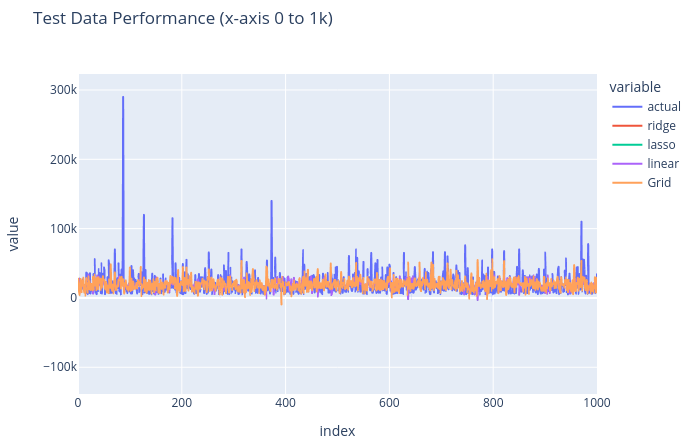

For both train and test data, we see pretty poor results.  When we zoom in, the Grid plot follows the price's pattern okay but the magnitudes are quite off at the higher values.  This is because the actual data is not scaled or smoothed by Ridge or Lasso.

# 4. Evaluation

Time and computing power were our main constraints for analyzing the used car dataset.  If time permitted, we would have been able to 
- try more iterations of which features to keep
- spent more time on filtering (quartile filtering could be tried instead of the eye-test)
- imputed missing data
- run individual models for features that had too many unique entries for OneHotEncoder (region, manufacturer, and model are all impactful features that were impractical for OneHotEncoder).

If we had more computing power, we could have
- run RFE to assist with feature selection
- run more hyperparameters in GridSearchCV.<br>

The data itself was very messy, requiring a lot of duplicate rows to be removed, features to be removed due to too many NA values, and pricing data to be filtered.  At the end, we were left with only 36% of the original data.  The methods and discipline in collecting the data must be vastly improved.<br>

The final dataset kept features: years_old, fuel, odometer, title_status, and transmission.  OneHotEncoder was used on categorical features and then linear regression, ridge, lasso, and polynomial features were run on all of the data.  Ridge and Lasso resulted in approximately the same errors as linear regression, so it doesn't matter which is selected in the model. 
 Hyperparameters were optimized using GridSearchCV, which resulted in ridge alpha = 0.1 and polynomial of 2.  We observed that the order of importance (coefficient magnitudes) are ordered as title_status, fuel, years_old, odometer, then transmission.<br>
 
The best R2 result we got was 0.35, meaning our best model explains 35% of the variance in price.  This is NOT a good score and the model needs more work in order to be confidently implemented.

# 5. Deployment

It is NOT recommended that we use the model as-is.  The model is currently at an R2 score of 35, which will not have a high success rate at predicting the price of a used car.<br>

It is recommended that instead a model is created for each dealership based on their region and the model of car sold.  These features had too many unique entries for OneHotEncoder but are undoubtedly two of the top features that would impact price.  To execute this, we should ask the dealership for these two pieces of information and then run the above GridSearchCV on the filtered data.<br>

For example, if San Francisco Toyota wants to know how much to charge for a 2020 Toyota Camry, we would first filter to only keep region='SF bay area'.  We can then filter out anything that contains 'Camry' in the 'model' column.  From there we can run the same code that was in this analysis - delete duplicates, delete na, delete outliers, then run GridsearchCV on a pipeline with OneHotEncoder, StandardScaler, PolynomailFeatures, Ridge (or Lasso).  We'd then check for an acceptable R2 score.  If all looks good, we can run .predict on any used car Toyota wants to sell.